In [2]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from numpy.linalg import norm
from tqdm import tqdm, tqdm_notebook
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input

In [3]:
#Initialize Model
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Define Function to extract Features 
def extract_features(img_path, model):
    
    #Preprocessing Input Image
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1])) #Reshape input image size into target size
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    
    #Getting features from the Image
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features


In [4]:
#Find Images in the Root Directiry and making list of those Images
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [5]:
# path to the datasets
root_dir = './datas'
filenames = sorted(get_file_list(root_dir))

In [6]:
#Extracting Features from each Image and saving them in a list
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

In [7]:
#Making pickle file of filenames and features of each files for future references
pickle.dump(feature_list, open('./features-ohou-resnet.pickle', 'wb'))
pickle.dump(filenames, open('./filenames-ohou.pickle','wb'))

In [8]:
#Getting filenames and features from pickle files
filenames = pickle.load(open('./filenames-ohou.pickle', 'rb'))
feature_list = pickle.load(open('./features-ohou-resnet.pickle', 'rb'))

In [9]:
# 폴더명에 따라 학습 진행 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('./datas_sub/', class_mode='categorical')

Found 126 images belonging to 2 classes.


In [10]:
print(train_generator.filenames[3])

chair\chair_114627.png


In [11]:
file_names = []
labels = []
for files in train_generator.filenames:
    file = files.split('\\')[1]
    label = files.split('\\')[0]
    file_names.append(file)
    labels.append(label)

In [12]:
df = pd.DataFrame({'img_id':file_names, 'img_repr': feature_list, 'label': labels})

In [13]:
df.head()

,img_id,img_repr,label
0,chair_111084.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chair
1,chair_111191.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chair
2,chair_111255.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00014535715, ...",chair
3,chair_114627.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chair
4,chair_125457.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chair


In [14]:
# 비교 대상의 이미지는 target 라벨 
df[df['label']=='target']

,img_id,img_repr,label
124,target_1.PNG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",target
125,target_2.PNG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",target


In [15]:
len(df['img_repr'][0])

100352

In [16]:
from annoy import AnnoyIndex
import random

f = len(df['img_repr'][0])
t = AnnoyIndex(f, metric='euclidean')

for i in tqdm(range(len(feature_list))):
    t.add_item(i, feature_list[i])
    
_ = t.build(150)

100%|██████████| 126/126 [00:02<00:00, 59.83it/s]


In [17]:
#Defining function to get similar images output in dataframe of the base image index we give as parameter

def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label  = df.iloc[img_index, [0, 1, 2]]
    similar_img_ids = t.get_nns_by_item(img_index, 4)
    end = time.time()
    # Now we want to get the 5 elements sorted by its euclidean distance relative to the image indexed item
    print(f'{(end - start) * 1000} ms')
    return base_img_id, base_label, df.iloc[similar_img_ids[1:]]

In [37]:
# 타켓 이미지 중 첫번째를 가져옴 
target_index = df[df['label']=='target'].index[0]
target_index

125

In [19]:
#Querying the AnnoyIndex    
base_image, base_label, similar_images_df = get_similar_images_annoy(target_index)


18.00704002380371 ms


In [20]:

print('Base Image Id:', 'chair_' +base_image)
print('Base Image Label:', base_label)


Base Image Id: chair_target_2.PNG
Base Image Label: target


In [21]:
#Dataframe of similar images
similar_images_df.tail()

,img_id,img_repr,label
23,chair_226826.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chair
102,chair_49198.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chair
4,chair_125457.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chair


In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as img 
from PIL import Image  
import cv2 as cv

In [23]:
def show_images(root_dir):
    plt.figure(figsize = (16,9))
    
    plt.subplot(1,4,1)
    path = os.path.join(root_dir, base_label, base_image)
    image = Image.open(path)
    plt.imshow(image)
    plt.title('Base Image')
    plt.axis('off')
    
    for i in range(len(similar_images_df)):
        path = os.path.join(root_dir, similar_images_df.iloc[i,2],similar_images_df.iloc[i,0])
        image = Image.open(path)
        plt.subplot(1,4,i+2)
        plt.imshow(image)
        plt.title('Similar Image')
        plt.axis('off')

In [24]:
root_dir

'./datas'

0.13300037384033203


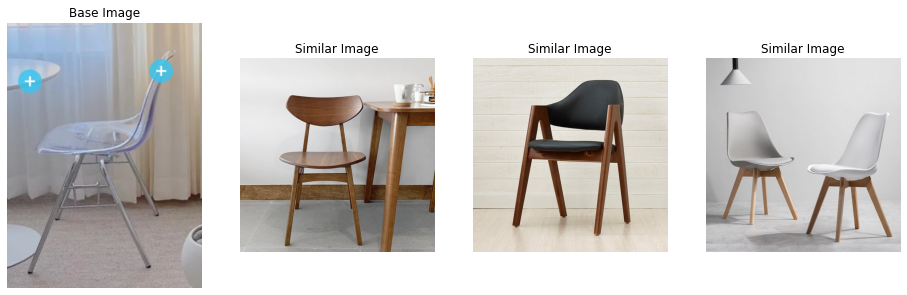

In [26]:
import time 
start = time.time()

root_dir = './datas_sub'
show_images(root_dir)

print(time.time()-start)